## Comparison of 201905 Model Phytoplankton to HPLC Phytoplankton Abundances from Nina Nemcek

In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

Note: crypto+hapto+prasino grouping was actually determined based on comparisons to 201812 model run

## Load data and matched model output

In [2]:
modSourceDir= '/results2/SalishSea/nowcast-green.201905/'
modver='201905'
Chl_N=1.8 # Chl:N ratio
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [6]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [7]:
if os.path.isfile('matched_'+modver+datestr+'_NewALLO.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'_NewALLO.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018_NewALLO.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    #df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    #df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    #df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    #df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'].values,df['Lat'].values),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'].values,df['Lat'].values),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'].values,df['p'].values,df['Lon'].values,df['Lat'].values)
    df['CT']=gsw.CT_from_t(df['SA'].values,df['Temperature'].values,df['p'].values)
    df.rename({'TchlA':'TchlA (ug/L)','Raphido':'Raphidophytes','Dinoflagellates-1':'Dinoflagellates',
            'Dictyo':'Dictyochophytes'},axis=1, inplace=True, errors='raise')
    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'_NewALLO.pkl','wb') as f:
        pickle.dump(data,f)

In [8]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [9]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [10]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

### What do HPLC-based observations look like in terms of species composition?

In [11]:
hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')

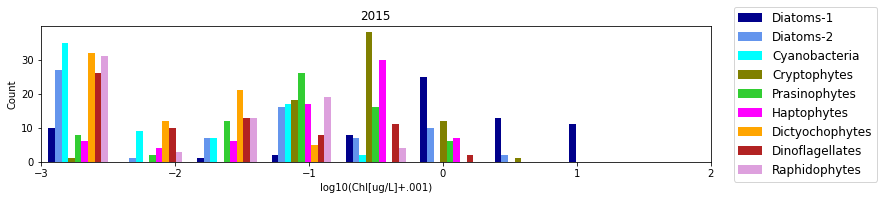

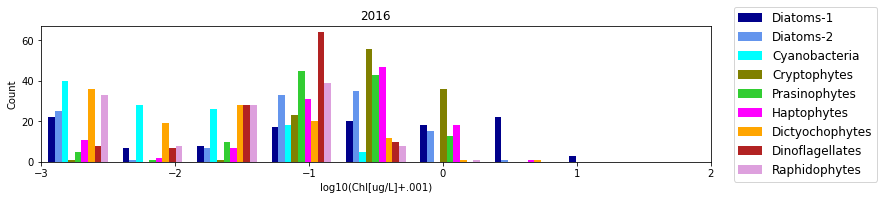

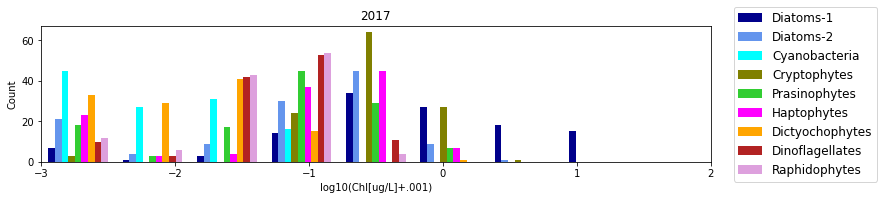

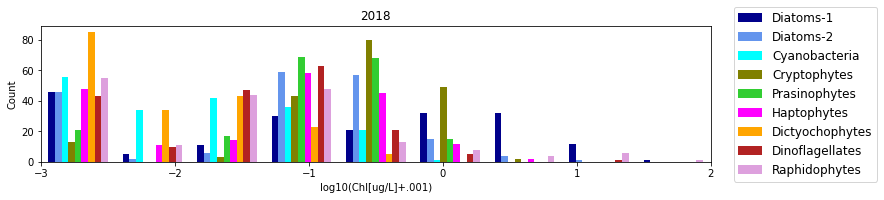

In [12]:
### Histogram by Year:
for year in range(2015,2019):
    fig,ax=plt.subplots(1,1,figsize=(12,2.5))
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(data[data.Year==year][el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    fig.legend(prop={'size': 12},loc='center right',bbox_to_anchor=[1.1,.5,0,0]);
    ax.set_xlim(-3,2)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title(year)

- The most abundant groups are diatoms-1
- Medium abundance groups includ cryptophytes, prasinophytes, haptophytes, and raphidophytes, and dinoflagellates
- Low abundance groups include cyanobacteria and dictyochophytes
- The dinoflagellate contribution was higher in 2016-2018 compared to 2015.

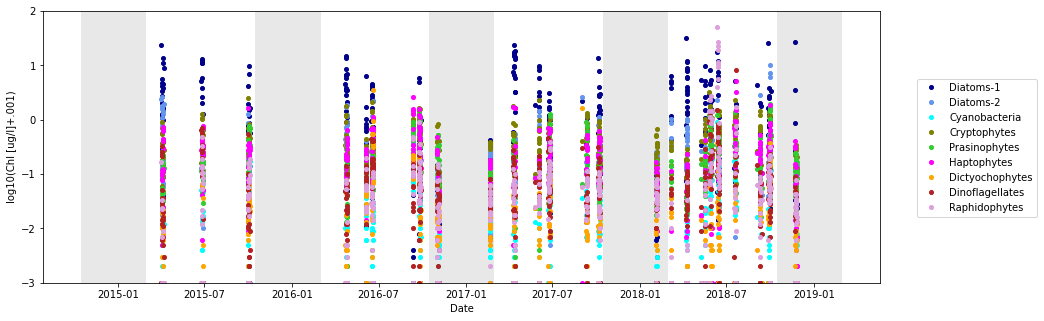

In [13]:
x=np.array([logt(data[el]) for el in hplclist]).T
fig,ax=plt.subplots(1,1,figsize=(15,5))
for i in range(0,len(hplclist)):
    ax.plot(data['dtUTC'],x[:,i],'o',color=cols[i],label=hplclist[i],ms=4)
fig.legend(loc='center right',bbox_to_anchor=[1.05,.5])
ax.set_ylim(-3,2)
ax.set_xlabel('Date')
ax.set_ylabel('log10(Chl [ug/l]+.001)')
for i in range(2015,2020):
    ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)

- Diatoms-1 peak during the spring bloom, but are high most of thte time.
- Diatoms-2 are lower abundance than diatoms-1 and show a less consistent seasonal pattern; they bloomed in spring 2015 and fall 2018
- Cryptophytes make up a consistent medium-level contribution
- Raphidophytes bloomed in summer 2018 in many samples
- Dictyochophytes exhibit occasional isolated high values but are often low abundance
- Dinoflagellates also exhibit occasional bloom values and generally low-to-medium abundance

## Model vs Obs Plots for various model-obs groups

- HPLC agreement for 201905 diatoms is not as strong as for 201805, but non-diatom agreement might be slightly better. 
- There is a separation between low and high model values for non-diatoms that is not present in 201812 comparisons

### By time of year

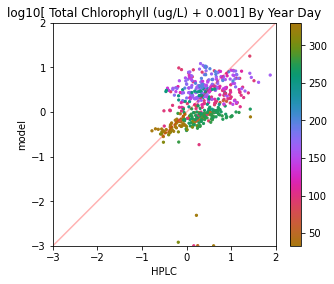

In [14]:
fig,ax=plt.subplots(1,1,figsize=(5,4.1))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],s=5,cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-3,2)
ax.set_ylim(-3,2);
ax.set_aspect(1)
fig.colorbar(m)

- Winter chlorophyll agrees with HPLC
- Spring bloom chlorophyll can be too low or too high; this likely reflects poor spring bloom timing
- Summer chlorophyll tends high
- fall chlorophyll tends low

### Correlation Coefficient Matrix

In [15]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CPH']=data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

In [16]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.129174,-0.044520,-0.104293,-0.155529,-0.089528,-0.038014,0.068507,0.186019,0.986013,-0.143394,0.799078,0.329545,-0.107524,0.086555,0.240522
Diatoms-2,0.129174,1.000000,0.087055,0.065789,0.041872,0.045439,0.204256,0.030159,0.089479,0.292639,0.067138,0.278908,0.068727,-0.136186,-0.003254,-0.009364
Cyanobacteria,-0.044520,0.087055,1.000000,0.455047,0.673585,0.265069,0.134517,0.111427,0.471045,-0.028299,0.565312,0.323326,-0.064953,0.271249,0.028373,0.083302
Cryptophytes,-0.104293,0.065789,0.455047,1.000000,0.629727,0.330846,0.059123,0.105006,0.151756,-0.089512,0.850031,0.145622,0.107619,0.283430,0.018542,0.238735
Prasinophytes,-0.155529,0.041872,0.673585,0.629727,1.000000,0.273744,0.115485,0.043839,0.193154,-0.142939,0.760689,0.115373,-0.114043,0.288055,-0.032531,0.043383
Haptophytes,-0.089528,0.045439,0.265069,0.330846,0.273744,1.000000,0.028364,-0.005455,-0.014300,-0.078695,0.718854,0.040637,-0.024129,0.309359,0.041182,0.139303
Dictyochophytes,-0.038014,0.204256,0.134517,0.059123,0.115485,0.028364,1.000000,0.070478,0.073749,-0.002326,0.079637,0.084752,-0.061454,0.083663,-0.033596,-0.014315
Dinoflagellates,0.068507,0.030159,0.111427,0.105006,0.043839,-0.005455,0.070478,1.000000,0.224567,0.071130,0.063264,0.247006,0.051962,0.131246,0.028659,0.114278
Raphidophytes,0.186019,0.089479,0.471045,0.151756,0.193154,-0.014300,0.073749,0.224567,1.000000,0.194417,0.130332,0.697246,0.198755,-0.038571,0.003086,0.153761
DD,0.986013,0.292639,-0.028299,-0.089512,-0.142939,-0.078695,-0.002326,0.071130,0.194417,1.000000,-0.126991,0.817431,0.329332,-0.126575,0.082919,0.230362


##### Strongest correlations:
Model diatoms and:
- Total chla: 0.343112
- Diatoms-1: 0.329545
- Diatoms-1+Diatoms-2: 0.329332

Model flagellates and:
- crypto+hapto+prasino: 0.377130
- haptophytes: 0.309359
- prasinophytes: 0.288055
- cryptophytes: 0.283430
- cyanobacteria: 0.271249 (but remember that cyanobacteria abundances are low)

### Variance-Covariance Matrix

In [17]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.030227,0.383433,-0.014114,-0.180451,-0.176579,-0.147258,-0.029133,0.111324,2.290018,17.413661,-0.504288,19.195920,2.849766,-0.540311,0.080426,2.389881
Diatoms-2,0.383433,0.517381,0.004810,0.019841,0.008286,0.013027,0.027284,0.008542,0.191999,0.900814,0.041154,1.167819,0.103589,-0.119279,-0.000527,-0.016217
Cyanobacteria,-0.014114,0.004810,0.005901,0.014656,0.014236,0.008116,0.001919,0.003371,0.107947,-0.009303,0.037008,0.144586,-0.010456,0.025373,0.000491,0.015408
Cryptophytes,-0.180451,0.019841,0.014656,0.175789,0.072638,0.055288,0.004603,0.017336,0.189807,-0.160610,0.303715,0.355411,0.094552,0.144700,0.001750,0.241003
Prasinophytes,-0.176579,0.008286,0.014236,0.072638,0.075690,0.030017,0.005900,0.004749,0.158524,-0.168293,0.178345,0.184770,-0.065746,0.096499,-0.002015,0.028737
Haptophytes,-0.147258,0.013027,0.008116,0.055288,0.030017,0.158861,0.002099,-0.000856,-0.017002,-0.134231,0.244167,0.094285,-0.020153,0.150141,0.003696,0.133684
Dictyochophytes,-0.029133,0.027284,0.001919,0.004603,0.005900,0.002099,0.034487,0.005154,0.040856,-0.001849,0.012603,0.091620,-0.023915,0.018919,-0.001405,-0.006401
Dinoflagellates,0.111324,0.008542,0.003371,0.017336,0.004749,-0.000856,0.005154,0.155056,0.263792,0.119866,0.021229,0.566188,0.042876,0.062930,0.002541,0.108347
Raphidophytes,2.290018,0.191999,0.107947,0.189807,0.158524,-0.017002,0.040856,0.263792,8.899071,2.482017,0.331329,12.107873,1.242441,-0.140106,0.002073,1.104408
DD,17.413661,0.900814,-0.009303,-0.160610,-0.168293,-0.134231,-0.001849,0.119866,2.482017,18.314475,-0.463135,20.363739,2.953355,-0.659590,0.079900,2.373664


##### largest covariances:
Model diatoms and:
- TChlA: 4.185330
- Diatoms-1+Diatoms-2: 2.953355
- Diatoms-1: 2.849766
- Raphidophytes: 1.242441

Model flagellates and:
- crypto+hapto+prasino: 0.391340
- haptophytes: 0.150141
- cryptophytes: 0.144700

### Corr Coeff matrix with log transformed values:

In [18]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.158963,-0.183906,-0.200691,-0.330748,-0.178564,-0.022753,0.257098,-0.044532,-0.240631,0.620741,0.381332,-0.121685,0.098088,0.158253
Diatoms-2,0.158963,1.000000,-0.070727,-0.017724,-0.081120,-0.206987,0.260879,0.110120,-0.069205,-0.095680,0.117311,-0.054775,-0.295843,-0.045642,-0.179840
Cyanobacteria,-0.183906,-0.070727,1.000000,0.308677,0.391266,0.322685,0.341206,0.001006,0.323720,0.387215,0.114417,-0.177385,0.423884,0.162395,0.141110
Cryptophytes,-0.200691,-0.017724,0.308677,1.000000,0.705089,0.328445,0.337350,0.256664,0.383761,0.872284,0.077971,-0.057914,0.290401,0.036045,0.120324
Prasinophytes,-0.330748,-0.081120,0.391266,0.705089,1.000000,0.299601,0.401870,0.140807,0.462423,0.698793,-0.023818,-0.289977,0.340049,0.021557,0.023916
Haptophytes,-0.178564,-0.206987,0.322685,0.328445,0.299601,1.000000,0.204290,0.047297,0.189056,0.576696,0.063931,-0.102367,0.250856,0.062734,0.100466
Dictyochophytes,-0.022753,0.260879,0.341206,0.337350,0.401870,0.204290,1.000000,0.267118,0.337107,0.328808,0.131390,-0.229019,0.120689,-0.086112,-0.078591
Dinoflagellates,0.257098,0.110120,0.001006,0.256664,0.140807,0.047297,0.267118,1.000000,0.354625,0.246911,0.416244,0.176141,0.109616,0.039243,0.135781
Raphidophytes,-0.044532,-0.069205,0.323720,0.383761,0.462423,0.189056,0.337107,0.354625,1.000000,0.370869,0.227029,-0.102750,0.287205,0.039728,0.080884
CPH,-0.240631,-0.095680,0.387215,0.872284,0.698793,0.576696,0.328808,0.246911,0.370869,1.000000,0.125576,-0.084175,0.324159,0.059914,0.130502


### Cov matrix with log transformed values:

In [19]:

dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.707049,0.223426,-0.191222,-0.156507,-0.337293,-0.224417,-0.022976,0.263191,-0.054699,-0.169667,0.364806,0.476603,-0.084867,0.038920,0.104432
Diatoms-2,0.223426,1.157251,-0.060550,-0.011380,-0.068113,-0.214188,0.216906,0.092818,-0.069990,-0.055547,0.056765,-0.056367,-0.169885,-0.014911,-0.097714
Cyanobacteria,-0.191222,-0.060550,0.633347,0.146625,0.243042,0.247024,0.209872,0.000628,0.242199,0.166302,0.040958,-0.135042,0.180073,0.039249,0.056720
Cryptophytes,-0.156507,-0.011380,0.146625,0.356259,0.328485,0.188575,0.155626,0.120032,0.215341,0.280974,0.020934,-0.033067,0.092525,0.006534,0.036274
Prasinophytes,-0.337293,-0.068113,0.243042,0.328485,0.609223,0.224942,0.242433,0.086112,0.339321,0.294348,-0.008362,-0.216512,0.141680,0.005110,0.009428
Haptophytes,-0.224417,-0.214188,0.247024,0.188575,0.224942,0.925289,0.151881,0.035647,0.170967,0.299372,0.027662,-0.094195,0.128808,0.018326,0.048811
Dictyochophytes,-0.022976,0.216906,0.209872,0.155626,0.242433,0.151881,0.597360,0.161760,0.244945,0.137147,0.045678,-0.169324,0.049793,-0.020213,-0.030679
Dinoflagellates,0.263191,0.092818,0.000628,0.120032,0.086112,0.035647,0.161760,0.613904,0.261217,0.104403,0.146699,0.132020,0.045846,0.009338,0.053734
Raphidophytes,-0.054699,-0.069990,0.242199,0.215341,0.339321,0.170967,0.244945,0.261217,0.883823,0.188160,0.096005,-0.092404,0.144130,0.011343,0.038407
CPH,-0.169667,-0.055547,0.166302,0.280974,0.294348,0.299372,0.137147,0.104403,0.188160,0.291239,0.030483,-0.043455,0.093382,0.009820,0.035571


## Multiple Linear Regression: 

#### HPLC groups and model diatoms

In [20]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [21]:
m

array([ 0.07901177,  0.04038303, -2.37059036,  0.82620416, -0.80017277,
       -0.00327047, -0.28365716, -0.05637489,  0.08471479,  0.34857395])

In [22]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.07901176679205403
Diatoms-2 0.04038302960024198
Cyanobacteria -2.3705903602264917
Cryptophytes 0.8262041629489276
Prasinophytes -0.8001727730681525
Haptophytes -0.003270465217090235
Dictyochophytes -0.2836571600122384
Dinoflagellates -0.056374894317614846
Raphidophytes 0.08471478644049679
ones 0.34857395106817046


#### try again with a subset that showed some relationship (and diatoms-2):

In [23]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [24]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.08993110228472322
Diatoms-2 0.014188091706788641
Cryptophytes 0.3389072106820919
Raphidophytes 0.04688692509711265
ones 0.2897009806718322


In [25]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [26]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.09024331276536574
Cryptophytes 0.3406248379075281
Raphidophytes 0.04707605924340086
ones 0.2924781243022796


#### HPLC groups and model flagellates

In [27]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [28]:
m

array([-0.00191036, -0.16480308,  1.82122949,  0.17455955,  0.11920028,
        0.35375115,  0.27956835,  0.23419722, -0.04018753,  0.35021653])

In [29]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.0019103589958024306
Diatoms-2 -0.16480307826918028
Cyanobacteria 1.821229487184655
Cryptophytes 0.17455954744634916
Prasinophytes 0.11920028329070938
Haptophytes 0.35375115362128273
Dictyochophytes 0.27956835348460174
Dinoflagellates 0.2341972205331308
Raphidophytes -0.04018752832367504
ones 0.3502165306381572


In [30]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [31]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.010844167278902635
Cyanobacteria 0.78933658843036
Cryptophytes 0.14766098991975396
Prasinophytes 0.21859616028611023
Haptophytes 0.38112414890833923
Dictyochophytes 0.14293751829866547
Dinoflagellates 0.19024925143696172
ones 0.33693420147988185


#### look at Cryptophytes, Prasinophytes, and Haptophytes (+cyanobacteria), the groups that showed a relationship to flagellates in 201812

In [32]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [33]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 0.858602872673889
Cryptophytes 0.17220455649899657
Prasinophytes 0.21819670508290173
Haptophytes 0.37773976424820205
Dictyochophytes 0.1736729736655534
ones 0.3188227556509651


Diatoms:
- Cryptophytes 
- Diatoms-1 
- Raphidophytes 

Flagellates:
- Cyanobacteria 
- Cryptophytes 
- Prasinophytes
- Haptophytes
- maybe dinoflagellates
- cyanobacteria make up small fraction of abundance; Nina says leave out

M. rubrum:
- Cyanobacteria

None:
- Diatoms-2
- Dictyochophytes
- Dinoflagellates?

##### Nina says Do not include cyanos in flagellate-like group: they are not flagellates and their abundance is low

### Individual phytoplankton groups compared to  model groups (1:1 correspondence not expected)

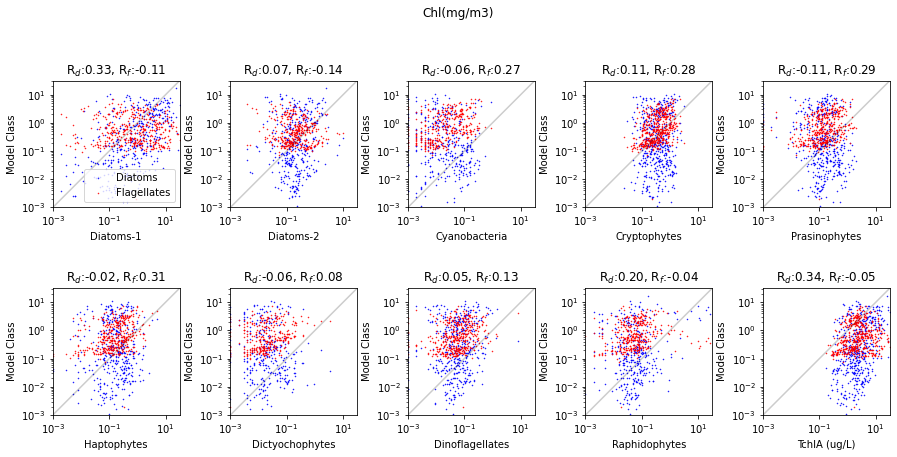

In [34]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ix=~np.isnan(np.squeeze(data.loc[:,[chplc[ii]]].values))
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',ms=1,color='blue',label='Diatoms')
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',ms=1,color='red',label='Flagellates')
    ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar1,'.',ms=1,color='blue',label='Diatoms')
    ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar2,'.',ms=1,color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    r1,p1=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar1[ix])
    r2,p2=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar2[ix])
    ax[ii].set_title(f"R$_d$:{r1:.2f}, R$_f$:{r2:.2f}")
    ax[ii].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
    ax[ii].set_xlim((10**-3,10**1.5))
    ax[ii].set_ylim((10**-3,10**1.5))
    ax[ii].set_aspect(1)
    ax[ii].set_xscale('log')
    ax[ii].set_yscale('log')
ax[0].legend()
#fig.suptitle('log10[Chl(mg/m3)+.001]');
fig.suptitle('Chl(mg/m3)');

### Separate into grouping for which there is some model-data agreement and plot model v obs

(-3.0, 1.5)

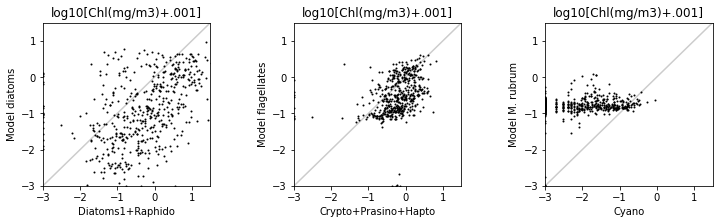

In [35]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.',ms=2)
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.',ms=2)
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Crypto+Prasino+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.',ms=2)
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

### Grouped Model-Obs Comparison: 

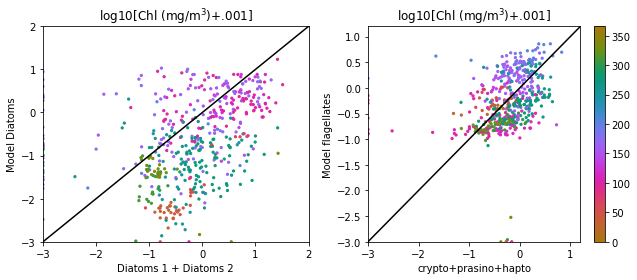

In [36]:
thresh=.8
msize=5
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
# ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')

##### look at summer separately (May-Aug)
- Agrees reasonably well for 201905

May-Aug


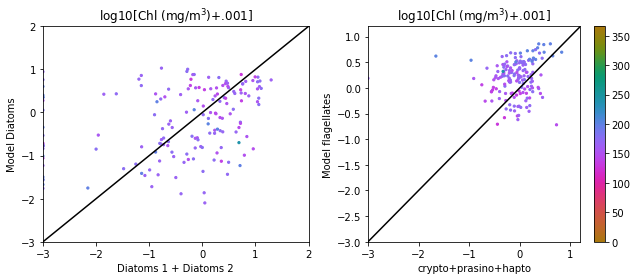

In [37]:
#thresh=.8
msize=5
data2=data.loc[(data['yd']>yd(dt.datetime(2015,5,1)))&(data['yd']<yd(dt.datetime(2015,9,1)))]
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data2['DD']),logt(data2['mod_diatoms_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data2['CPH']),logt(data2['mod_flagellates_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
# ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')
print('May-Aug')

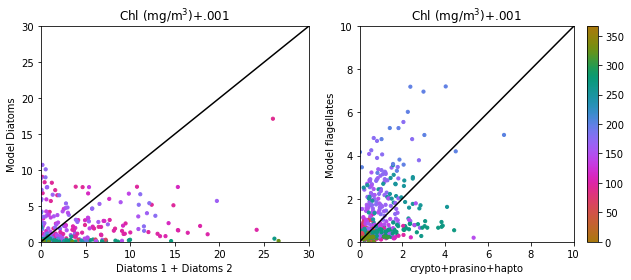

In [38]:

msize=10
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(data['DD'],data['mod_diatoms_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(data['CPH'],data['mod_flagellates_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('Chl (mg/m$^3$)+.001')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('Chl (mg/m$^3$)+.001')
ax[0].plot((0,30),(0,30),'k-')
ax[1].plot((0,10),(0,10),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('new')

### Linear fits to empirical groupings
- R^2 values are low

In [39]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['DD'],
                                                              data.loc[ii]['mod_diatoms_chl'])

In [40]:
slope, intercept, r_value*r_value

(0.16125795683686217, 0.7946825811125254, 0.10845956227659796)

In [41]:
ii=(data['CPH']>=0)&(data['mod_flagellates_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['CPH'],
                                                              data.loc[ii]['mod_flagellates_chl'])

In [42]:
slope, intercept, r_value*r_value

(0.5388676190446141, 0.5426070709199415, 0.1422266760037195)

In [43]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(logt(data.loc[ii]['DD']),
                                                              logt(data.loc[ii]['mod_diatoms_chl']))

In [44]:
slope, intercept, r_value*r_value

(0.29762210171936015, -0.6035847692143748, 0.09522667093021238)